# Задача 7. Нейронные сети

* **Дедлайн**: 31.05.2024, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
- Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- Использовать CrossEntropyLoss и L2-регуляризацию.
- Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- * (**+2 балла**) Добавить Batch normalization.
- * (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- * (**+1 балл**) Также реализовать оптимизатор Adam.

In [15]:
import torch
from torch import nn
import lightning as L
from torchvision.datasets import MNIST
from torch.nn import functional as F

# Данные
В качестве данных возьмём MNIST. Датасет представляет собой изображения цифр от 0 до 9. 

In [16]:
from torchvision.transforms import ToTensor

train_set = MNIST(root=".", download=True, train=True, transform=ToTensor())

torch_generator = torch.Generator().manual_seed(42)
train_set, val_set = torch.utils.data.random_split(
    train_set,
    [int(len(train_set) * 0.8), len(train_set) - int(len(train_set) * 0.8)],
    torch_generator,
)
test_set = MNIST(root=".", download=True, train=False, transform=ToTensor())

# Слои для сети

In [17]:
class FullyConnectedLayerFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight, bias):
        output = x @ weight + bias
        ctx.save_for_backward(x, weight)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        x, weight = ctx.saved_tensors
        x_grad = grad_output @ weight.T
        weight_grad = grad_output.T @ x
        bias_grad = grad_output.sum(0)

        return x_grad, weight_grad.T, bias_grad


class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features, out_features, dtype=torch.float):
        super().__init__()
        self.weight = nn.Parameter(torch.empty((in_features, out_features), dtype=dtype))
        self.bias = nn.Parameter(torch.empty(out_features, dtype=dtype))
        self.init_weights()

    def forward(self, x):
        return FullyConnectedLayerFunc.apply(x, self.weight, self.bias)

    def init_weights(self):
        nn.init.kaiming_normal_(
            self.weight, mode="fan_out", nonlinearity="relu"
        )
        nn.init.uniform_(self.bias, -0.5, 0.5)


class ReluLayer(nn.Module):
    def forward(self, x):
        return F.relu(x)

#### Проверка градиентов с помощью torch.autograd.gradcheck

In [18]:
torch.autograd.gradcheck(
    FullyConnectedLayerFunc.apply,
    (
        torch.rand((5, 20), requires_grad=True, dtype=torch.double),
        torch.rand((20, 10), requires_grad=True, dtype=torch.double),
        torch.rand(10, requires_grad=True, dtype=torch.double),
    ),
    eps=1e-6,
    atol=1e-4,
)

test_layer = FullyConnectedLayer(100, 200, dtype=torch.double)

torch.autograd.gradcheck(
    test_layer,
    (
        torch.rand((5, 100), requires_grad=True, dtype=torch.double)
    ),
    eps=1e-6,
    atol=1e-4,
)

True

# Adam

In [19]:
from torch.optim.optimizer import Optimizer


class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)
        self.state = dict()
        for group in self.param_groups:
            for param in group["params"]:
                self.state[param] = {
                    "m": torch.zeros_like(param),
                    "v": torch.zeros_like(param),
                    "g": torch.zeros_like(param),
                    "t": 0,
                }

    def step(self, closure=None):
        loss = None
        if closure:
            with torch.enable_grad():
                loss = closure()
        
        for group in self.param_groups:
            beta_1, beta_2 = group["betas"]
            for param in group["params"]:
                if param.grad is None:
                    continue
                
                grad = param.grad.data
                if group["weight_decay"] != 0:
                    grad += group["weight_decay"] * param.data
                state = self.state[param]
                state["t"] += 1
                state["m"] = beta_1 * state["m"] + (1 - beta_1) * grad
                state["v"] = beta_2 * state["v"] + (1 - beta_2) * grad**2
                m_hat = state["m"] / (1 - beta_1 ** state["t"])
                v_hat = state["v"] / (1 - beta_2 ** state["t"])

                param.data -= group["lr"] * m_hat / (torch.sqrt(v_hat) + group["eps"])
        
        return loss

# Нейронная сеть

In [8]:
class MyNeuralNetwork(nn.Module):
    def __init__(self, hidden_size=100, use_batch_norm=False):
        super().__init__()

        if not use_batch_norm:
            self.sequential = nn.Sequential(
                FullyConnectedLayer(28 * 28, hidden_size),
                ReluLayer(),
                FullyConnectedLayer(hidden_size, 10),
            )
        else:
            self.sequential = nn.Sequential(
                FullyConnectedLayer(28 * 28, hidden_size),
                ReluLayer(),
                nn.BatchNorm1d(hidden_size),
                FullyConnectedLayer(hidden_size, 10),
            )

    def forward(self, x):
        return self.sequential(x)
    

In [20]:
class LitModel(L.LightningModule):
    def __init__(
        self, hidden_size, use_batch_norm, optimizer, lr, weight_decay
    ):
        super().__init__()
        self.model = MyNeuralNetwork(
            hidden_size=hidden_size, use_batch_norm=use_batch_norm
        )
        self.optimizer = optimizer(
            self.model.parameters(), lr=lr, weight_decay=weight_decay
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = nn.functional.cross_entropy(logits, y)
        self.log("train_loss", loss.item(), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        logits = self.model(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = torch.sum(preds == y).item() / len(y)
        self.log_dict({"val_loss": loss.item(), "val_acc": acc})

    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        logits = self.model(x)
        preds = torch.argmax(logits, dim=1)
        acc = torch.sum(preds == y).item() / len(y)
        self.log_dict({"test_acc": acc})

    def configure_optimizers(self):
        return self.optimizer

# Обучение
Будем перебирать гиперпараметры: оптимизатор, lr, hidden_size и использование batch_norm

In [21]:
from lightning.pytorch.loggers import CSVLogger

optimizers = [
    ("SGD", torch.optim.SGD),
    ("Adam", Adam),
    ("RMSprop", torch.optim.RMSprop),
]

lrs = [1e-2, 1e-3, 1e-4]

hidden_sizes = [100, 1000, 1500]

for optimizer in optimizers:
    for lr in lrs:
        for hidden_size in hidden_sizes:
            for use_batch_norm in [False, True]:
                train_loader = torch.utils.data.DataLoader(
                    train_set, batch_size=4096, shuffle=True, num_workers=4
                )
                val_loader = torch.utils.data.DataLoader(
                    val_set, batch_size=4096, num_workers=4
                )
                test_loader = torch.utils.data.DataLoader(
                    test_set, batch_size=4096, num_workers=4
                )
                model = LitModel(
                    hidden_size=hidden_size,
                    use_batch_norm=use_batch_norm,
                    optimizer=optimizer[1],
                    lr=lr,
                    weight_decay=0.005,
                )

                logger = CSVLogger(
                    "logs",
                    name="simple_model",
                    #    version="test"
                )
                max_epochs = 2
                logger.log_hyperparams(
                    {
                        "max_epochs": max_epochs,
                        "lr": lr,
                        "optimizer": optimizer[0],
                        "hidden_size": hidden_size,
                        "use_batch_norm": use_batch_norm,
                    }
                )
                trainer = L.Trainer(
                    max_epochs=max_epochs,
                    logger=logger,
                    accelerator="gpu",
                    log_every_n_steps=5,
                    enable_model_summary=False,
                    enable_progress_bar=False,
                )
                trainer.validate(model, dataloaders=val_loader, verbose=False)
                trainer.fit(
                    model=model,
                    train_dataloaders=train_loader,
                    val_dataloaders=val_loader,
                )

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=2` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=2` reached.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using

Посмотрим точность с разными параметрами

In [22]:
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import yaml

versions = glob("logs/simple_model/*", recursive = True)

map_name_val = []

for version in versions:
    df = pd.read_csv(version + '/metrics.csv').dropna(subset=['val_acc'])
    
    with open(version + '/hparams.yaml') as f:
        hparams = yaml.safe_load(f)
    
    name = f"lr{hparams['lr']}_{hparams['optimizer']}_hsize{hparams['hidden_size']}_bn{hparams['use_batch_norm']}"
    map_name_val.append((round(df['val_acc'].iloc[-1], 3), name))

map_name_val.sort()
map_name_val

[(np.float64(0.075), 'lr0.0001_SGD_hsize100_bnFalse'),
 (np.float64(0.078), 'lr0.0001_SGD_hsize100_bnTrue'),
 (np.float64(0.085), 'lr0.0001_SGD_hsize1000_bnFalse'),
 (np.float64(0.099), 'lr0.001_SGD_hsize100_bnTrue'),
 (np.float64(0.1), 'lr0.0001_SGD_hsize1500_bnTrue'),
 (np.float64(0.102), 'lr0.001_SGD_hsize100_bnFalse'),
 (np.float64(0.106), 'lr0.0001_SGD_hsize1000_bnTrue'),
 (np.float64(0.11), 'lr0.0001_SGD_hsize1500_bnFalse'),
 (np.float64(0.114), 'lr0.001_SGD_hsize1000_bnFalse'),
 (np.float64(0.117), 'lr0.001_SGD_hsize1500_bnFalse'),
 (np.float64(0.224), 'lr0.01_SGD_hsize100_bnFalse'),
 (np.float64(0.266), 'lr0.001_SGD_hsize1000_bnTrue'),
 (np.float64(0.281), 'lr0.0001_Adam_hsize100_bnTrue'),
 (np.float64(0.287), 'lr0.001_SGD_hsize1500_bnTrue'),
 (np.float64(0.289), 'lr0.0001_Adam_hsize100_bnFalse'),
 (np.float64(0.455), 'lr0.01_SGD_hsize1000_bnFalse'),
 (np.float64(0.521), 'lr0.01_SGD_hsize1500_bnFalse'),
 (np.float64(0.574), 'lr0.01_SGD_hsize100_bnTrue'),
 (np.float64(0.664), 'l

Возьмём 4 лучших и обучим на большем числе эпох

In [24]:
from lightning.pytorch.loggers import CSVLogger

best_params = [
    (("Adam", Adam), 0.01, 1500, True),
    (("Adam", Adam), 0.01, 1000, True),
    (("RMSprop", torch.optim.RMSprop), 0.001, 1000, True),
    (("RMSprop", torch.optim.RMSprop), 0.001, 1500, True)
]

for (optimizer, lr, hidden_size, use_batch_norm) in best_params:
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=4096, shuffle=True, num_workers=8
    )
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=4096, num_workers=8
    )
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=4096, num_workers=8
    )
    model = LitModel(
        hidden_size=hidden_size,
        use_batch_norm=use_batch_norm,
        optimizer=optimizer[1],
        lr=lr,
        weight_decay=0.005,
    )

    logger = CSVLogger(
        "logs",
        name="simple_model_selected_params",
    )
    max_epochs = 20
    logger.log_hyperparams(
        {
            "max_epochs": max_epochs,
            "lr": lr,
            "optimizer": optimizer[0],
            "hidden_size": hidden_size,
            "use_batch_norm": use_batch_norm,
        }
    )
    trainer = L.Trainer(
        max_epochs=max_epochs,
        logger=logger,
        accelerator="gpu",
        log_every_n_steps=5,
        enable_model_summary=False,
        enable_progress_bar=False,
    )
    trainer.validate(model, dataloaders=val_loader, verbose=False)
    trainer.fit(
        model=model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader,
    )
    trainer.test(model, dataloaders=test_loader, verbose=False)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (

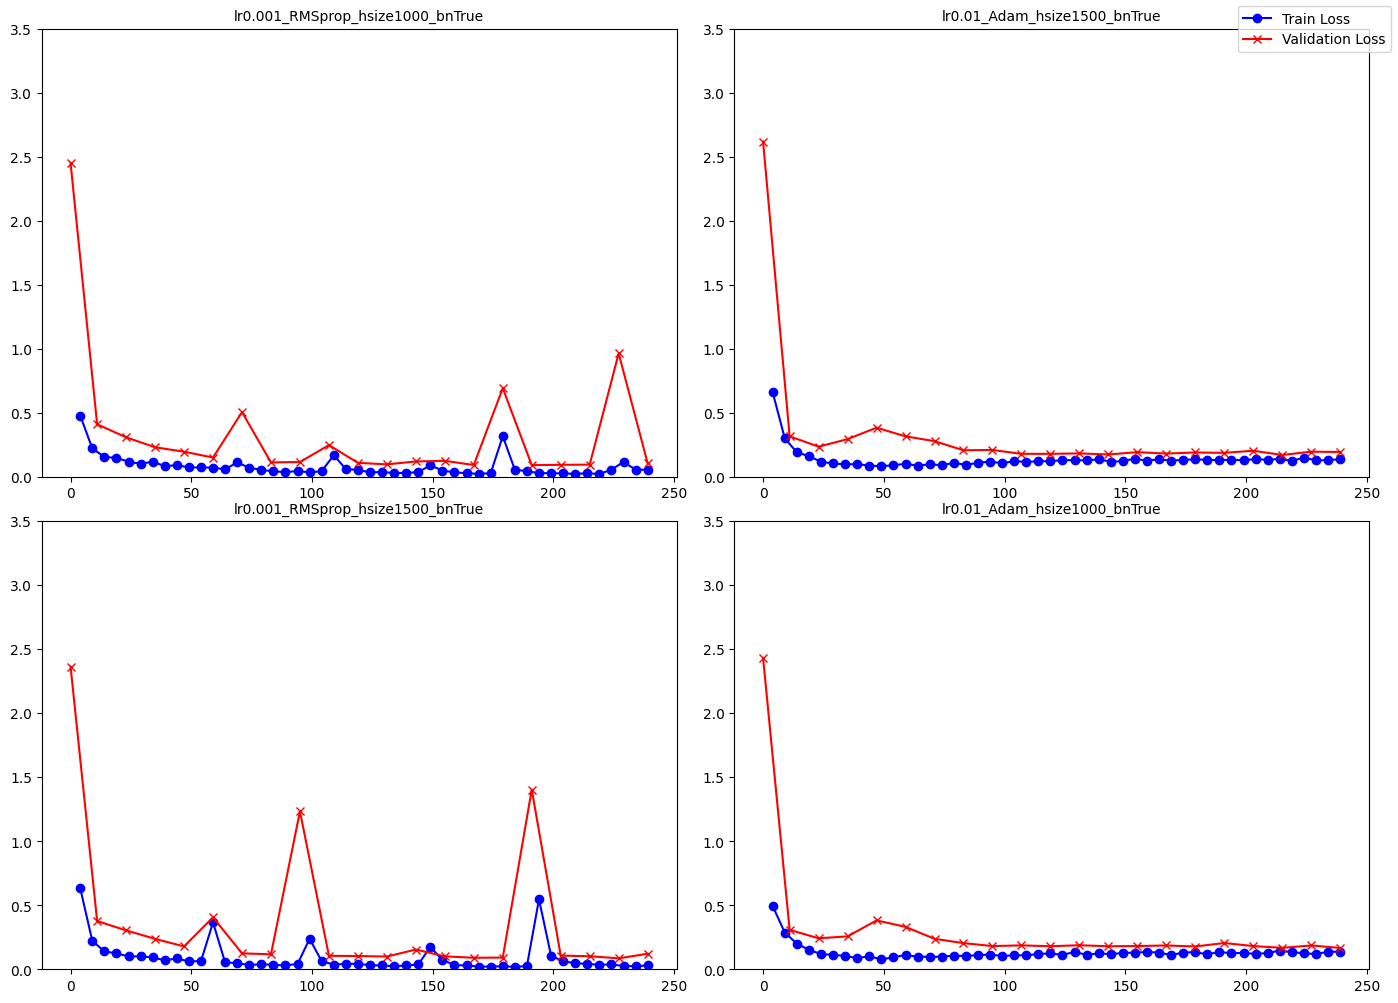

In [25]:
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import yaml

versions = glob("logs/simple_model_selected_params/*", recursive=True)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.tight_layout()

coords = [(x, y) for x in range(2) for y in range(2)]


for coord, version in zip(coords, versions):
    df = pd.read_csv(version + "/metrics.csv")
    df_ = df.dropna(subset=["train_loss"])
    ax = axs[coord[0]][coord[1]]
    ax.set_ylim([0, 3.5])
    ax.plot(
        df_["step"],
        df_["train_loss"],
        label="Train Loss",
        color="blue",
        marker="o",
    )
    df_ = df.dropna(subset=["val_loss"])
    ax.plot(
        df_["step"],
        df_["val_loss"],
        label="Validation Loss",
        color="red",
        marker="x",
    )

    with open(version + "/hparams.yaml") as f:
        hparams = yaml.safe_load(f)

    ax.set_title(
        f"lr{hparams['lr']}_{hparams['optimizer']}_hsize{hparams['hidden_size']}_bn{hparams['use_batch_norm']}",
        fontsize=10
    )
    # fig.xlabel('Step')
    # ax.ylabel('Loss')
# plt.legend()
lines_labels = [axs[0][0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels)

In [26]:
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import yaml

versions = glob("logs/simple_model_selected_params/*", recursive = True)

map_name_val = []

for version in versions:
    df = pd.read_csv(version + '/metrics.csv').dropna(subset=['val_acc'])
    
    with open(version + '/hparams.yaml') as f:
        hparams = yaml.safe_load(f)
    
    name = f"lr{hparams['lr']}_{hparams['optimizer']}_hsize{hparams['hidden_size']}_bn{hparams['use_batch_norm']}"
    map_name_val.append((round(df['val_acc'].iloc[-1], 3), name))

map_name_val.sort()
map_name_val

[(np.float64(0.957), 'lr0.01_Adam_hsize1500_bnTrue'),
 (np.float64(0.963), 'lr0.01_Adam_hsize1000_bnTrue'),
 (np.float64(0.966), 'lr0.001_RMSprop_hsize1500_bnTrue'),
 (np.float64(0.972), 'lr0.001_RMSprop_hsize1000_bnTrue')]

Наилучшую точность набирает модель с параметрами:
learning rate=0.001  
optimizer=RMSprop  
hidden_size=1000  
и с использованием Batch normalization  

# Accuracy на тестовых данных

In [27]:
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import yaml

version = glob("logs/simple_model_selected_params/*", recursive = True)[2]


df = pd.read_csv(version + '/metrics.csv').dropna(subset=['test_acc'])
with open(version + '/hparams.yaml') as f:
    hparams = yaml.safe_load(f)
print(f"lr{hparams['lr']}_{hparams['optimizer']}", df['test_acc'].iloc[0])



lr0.001_RMSprop 0.9639000296592712
